# Example Policy Evaluation Notebook

This notebook describes the policy evaluation tools available in `pc-gym`

In [1]:
from pcgym import make_env
import numpy as np 
from stable_baselines3 import PPO, SAC
from pcgym import reproducibility_metric

In [2]:
# Enter required setpoints for each state.
T = 26
nsteps = 100
SP = {
    'Ca': [0.85 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

In [4]:
# Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}

# Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 1e3 #Reward scale for each state
}
env_params = {
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'SP':SP, # Setpoint
    'o_space' : observation_space, # Observation space
    'a_space' : action_space, # Action space
    'x0': np.array([0.8,330,0.8]), # Initial conditions 
    'model': 'cstr', # Select the model
    'r_scale': r_scale, # Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, # Normalise the actions
    'normalise_o':True, # Normalise the states,
    'noise':True, # Add noise to the states
    'integration_method': 'casadi', # Select the integration method
    'noise_percentage':0.001 # Noise percentage
}
env = make_env(env_params)

In [5]:
nsteps_learning = 1e4
PPO_policy = PPO('MlpPolicy', env, verbose=1,learning_rate=0.001).learn(nsteps_learning)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -85.3    |
| time/              |          |
|    fps             | 1338     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99          |
|    ep_rew_mean          | -110        |
| time/                   |             |
|    fps                  | 1021        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004731682 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [6]:
SAC_policy = SAC('MlpPolicy', env, verbose=1,learning_rate=0.001).learn(1.5e3)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -86.7    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 57       |
|    time_elapsed    | 6        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | 0.0218   |
|    critic_loss     | 0.257    |
|    ent_coef        | 0.745    |
|    ent_coef_loss   | -0.488   |
|    learning_rate   | 0.001    |
|    n_updates       | 295      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -61.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 45       |
|    time_elapsed    | 17       |
|    total_timesteps | 792      |
| train/             |

The following code shows the policy and oracle comparison capability. The oracle is defined as a NMPC with perfect model (oracle uses ocp with control cost which differs from the reward function used by the RL agent) and can be sensitive to tuning of the horizon and control cost. A visualisation of the reward distribution can also be shown using `dist_reward`.

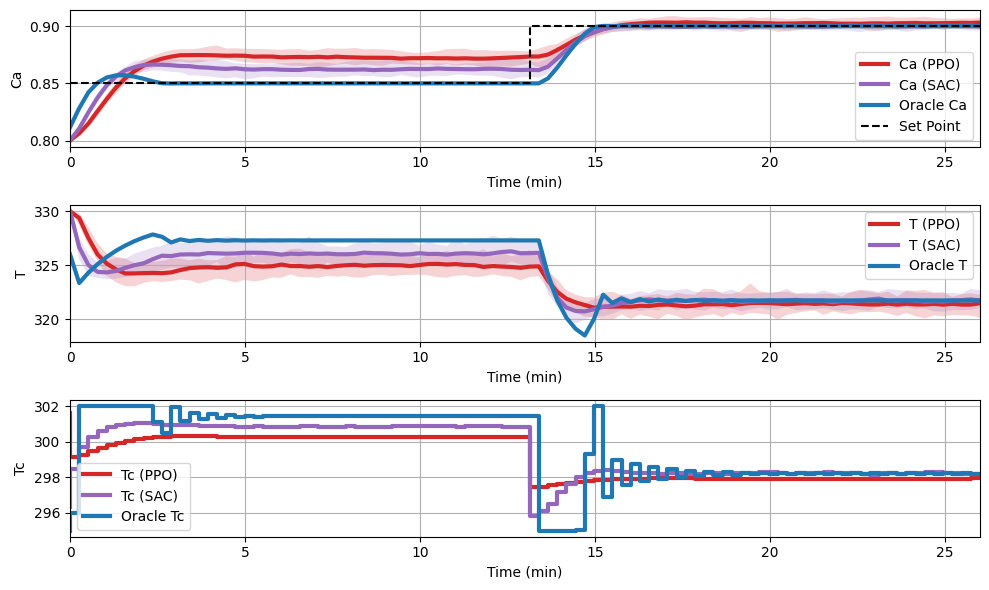

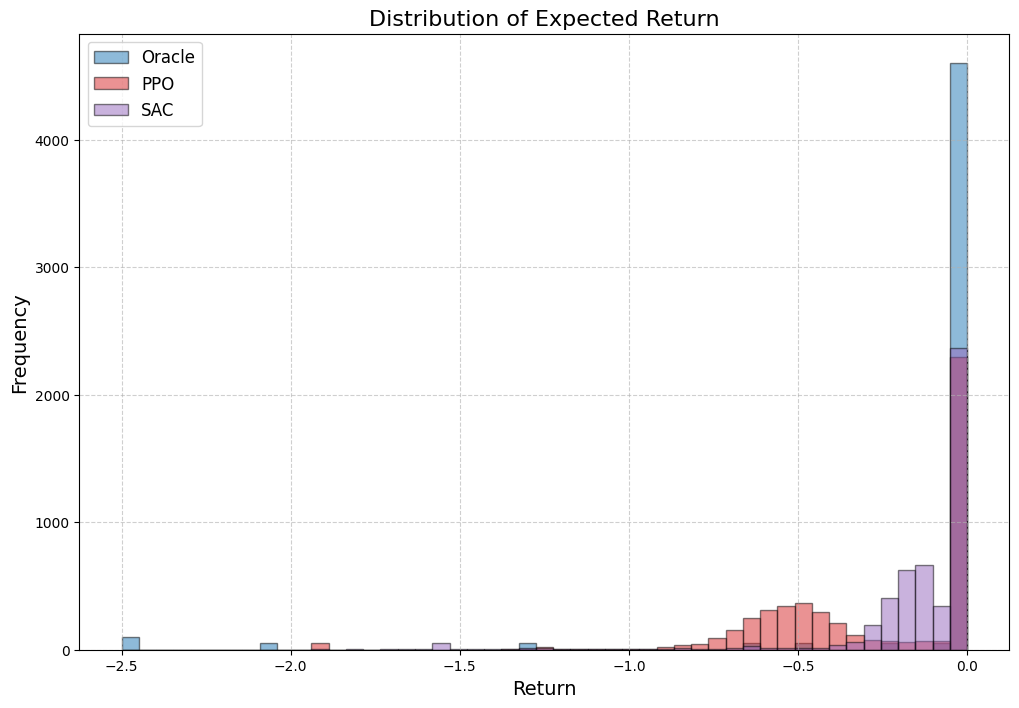

In [8]:
evaluator, data = env.plot_rollout({'PPO': PPO_policy,'SAC':SAC_policy}, reps = 50, oracle=True, dist_reward=True)

The `pc-gym` can also calculate dispersion and performance metrics of the distribution of rewards to allow the user to evaluate their policy.

In [ ]:
policy_measure = reproducibility_metric(dispersion='mad', performance='mean', scalarised_weight=2e3)
scalarised_performance = policy_measure.evaluate(evaluator, component='r')

print('scalarised_performance: ', scalarised_performance)

scalarised_performance {'oracle': {'r': array([801.51417093])}, 'PPO': {'r': array([3078.90847064])}, 'SAC': {'r': array([1493.78017083])}}
